# Simulating your income 

##### Jiang Wang

#### Import packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import matplotlib.mlab as mlab
import scipy.stats as sstats
from ggplot import *

D:\Users\Jiang\Anaconda3\lib\site-packages\ggplot\utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
D:\Users\Jiang\Anaconda3\lib\site-packages\ggplot\stats\smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp
D:\Users\Jiang\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Question 1

Let the standard deviation of your income process be σ = 0.1, let the persistence be ρ = 0.2,
let the long-run growth rate of income be g = 0.03, and let the average initial income be inc0 = $80, 000.
Assume you will work for 40 years after you graduate (2019 to 2058). Simulate 10,000 different
realizations of your lifetime income. Do this by first drawing 10,000 sets of 40 normally distributed
errors with mean 0 and standard deviation σ = 0.1. Then plug those into the income process defined
above to simulate your lifetime income. Plot one of the lifetime income paths. Make sure your axes are
correctly labeled and your plot has a title.

In [2]:
# define the initial statistics
profileA = {
    'inc_0'       : 80000,       # average initial income for MACSS graudates
    'g'           : 0.03,        # long run annual growth rate for the annual salary
    'rho'         : 0.2,         # persistence coefficient
    'st_year'     : int(2019),   # start years
    'w_years'     : 40,          # years to work
    'mean'        : 0,           # expectation of errors
    'SD'          : 0.1,         # standard deviation
    'num_draws'   : 10000        # number of simulations
}

#### simulation function

In [3]:
def sim(p):
    
    # set random seed
    np.random.seed(127)
    
    # set random errors
    # 10,000 sets of 40 normally distributed errors
    n_errors = np.random.normal(p['mean'], p['SD'], (p['w_years'], p['num_draws']))
    
    # create a matrix of 0 - dim (c_years, num_draws)
    ln_income_mat = np.zeros((p['w_years'], p['num_draws']))
    
    # fill the matrix
    ln_income_mat[0, :] = np.log(p['inc_0']) + n_errors[0, :]
    
    # loop and apply model
    for yr in range(1, p['w_years']):
        ln_income_mat[yr, :] = (1 - p['rho']) * (np.log(p['inc_0']) + p['g'] * yr) +\
                                p['rho'] * ln_income_mat[yr - 1, :] + n_errors[yr, :]
    
    # convert from logrithms to numbers (R)
    income_mat = np.exp(ln_income_mat)
    
    # return matrix
    return income_mat

#### generate income matrix

In [4]:
income_mat = sim(profileA)

##### Create Indexes

In [5]:
years = np.arange(profileA['st_year'], profileA['st_year'] + profileA['w_years']).tolist()
# years should be a list

##### Transform Numpy Arrays Into Useful Dataframe

In [6]:
pdincome = pd.DataFrame(income_mat).T
# why assign to columns instead of rows?
pdincome.columns = years
pdincome = pdincome.T
pdincome['year'] = pdincome.index
pmelt = pd.melt(pdincome, id_vars='year', var_name='id')

##### Data Selection (by individual)

In [7]:
# Select the 501th person
individual = 500
pidata = pmelt.loc[lambda s: s.id==individual]

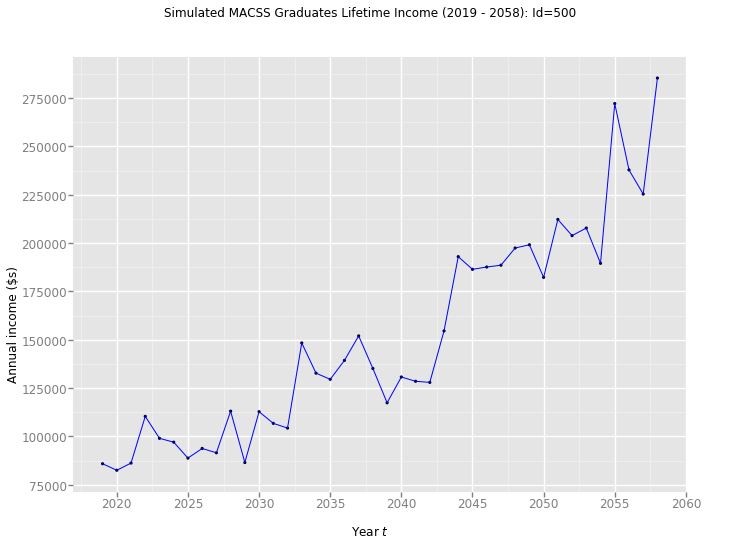

<ggplot: (-9223371949313283836)>

In [8]:
ggplot(aes(x='year', y='value'), data=pidata) +\
    geom_line(color = "blue", size = 1) +\
    geom_point(size = 10) +\
    labs(title = f'Simulated MACSS Graduates Lifetime Income (2019 - 2058): Id={individual}',
       x = r'Year $t$', y = r'Annual income (\$s)')

# Question 2

Plot a histogram with 50 bins of year t = 2019 initial income for each of the 10,000 simulations. What percent of your class will earn more than \$100,000 in the first year out of the program? What percent of the class will earn less than $70,000? Is the distribution normally distributed (i.e. symmetric and bell-curved)?

##### I am having some problems calling stat_function (not defined). I suspect there may be some errors in the ggplot package in python, and therefore I use matplot here instead.

##### Calculate mu(mean), sigma(sd)

In [9]:
s_year = 2019

In [10]:
income2019 = income_mat[s_year-2019, :]
mu = np.mean(income2019)
sigma = (np.var(income2019))**0.5

##### Plotting

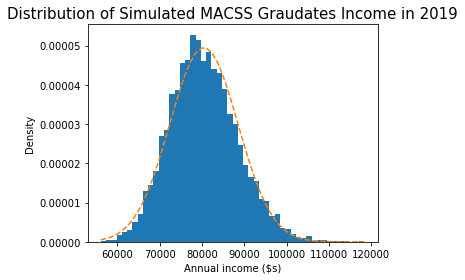

In [11]:
fig, ax = plt.subplots()

n, bins, patches = ax.hist(x=income2019, bins=50, normed=1)

ax.plot(bins, mlab.normpdf(bins, mu, sigma), '--')
ax.set_xlabel(r'Annual income (\$s)')
ax.set_ylabel('Density')
ax.set_title(f'Distribution of Simulated MACSS Graudates Income in {s_year}',fontsize=15)

fig.tight_layout()
plt.show()

#### Normally Distributed?

The incomes do appear to be normally distributed because the histogram fits the dashed normal curve well.

#### Percentile Calculation

In [12]:
sstats.percentileofscore(income2019, 70000)

8.8499999999999996

In [13]:
100 - sstats.percentileofscore(income2019, 100000)

1.2800000000000011

Based on the above calculations, in this simulated data, about 8.85% of the class will earn less than \$70,000, and about 1.28%  will earn more than \$100,000 in their first year out of the program.

# Question 3

Suppose you graduate from the MACSS program with $95,000 of zero-interest debt. You
will use 10% of your annual salary after you graduate to pay off this loan. Plot the histogram of how
many years it takes to pay off the loan in each of your 10,000 simulations. This histogram will only
have as many bins as you have unique years in which people pay off their debt. In what percent of the
simulations are you able to pay off the loan in 10 years (on or before t = 2028)?

In [14]:
debt = 95000
rate = 0.1
cum_payment = np.zeros(profileA['num_draws'])
debt_years = np.zeros(profileA['num_draws'])

In [15]:
for i in range(profileA['num_draws']):
    for j in range(profileA['w_years']):
        cum_payment[i] += rate * income_mat[j, i]
        if cum_payment[i] >= 95000:
            debt_years[i] = profileA['st_year'] + j
            break  

##### plotting

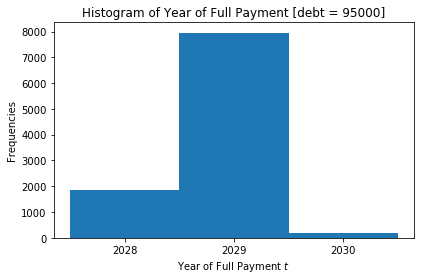

In [16]:
%matplotlib inline
fig, ax = plt.subplots()

plt.hist(debt_years, np.arange(min(debt_years)-.5, max(debt_years) + 1))

plt.xlabel(r'Year of Full Payment $t$')
plt.ylabel('Frequencies')
plt.title(f'Histogram of Year of Full Payment [debt = {debt}]')
plt.xticks(np.arange(min(debt_years), max(debt_years) + 1))

fig.tight_layout()
plt.show()

In what percent of the simulations are you able to pay off the loan in 10 years (on or before 2028)?

In [17]:
len(list(i for i in debt_years if i<= 2028))/len(debt_years)

0.1844

18.44% of the simulations are able to pay off the loan in 10 years (on or before 2028)

# Question 4

Now suppose that the UChicago MACSS program becomes very well known in the next
year, and the skills you are learning are demanded more by employers. This increases the average
starting salary to inc0 = \$85, 000, but the standard deviation in incomes increases also to σ = 0.15.
Plot the new histogram of how many years it takes to pay off your loan of \$95,000 in your new 10,000
simulations with the new standard deviation and the new average initial salary. In what percent of the
simulations are you able to pay off the loan in 10 years (on or before t = 2028)?

In [18]:
# define new statistics
profileB = {
    'inc_0'       : 85000,       # average initial income for MACSS graudates
    'g'           : 0.03,        # long run annual growth rate for the annual salary
    'rho'         : 0.2,         # persistence coefficient
    'st_year'     : int(2019),   # start years
    'w_years'     : 40,          # years to work
    'mean'        : 0,           # expectation of errors
    'SD'          : 0.15,         # standard deviation
    'num_draws'   : 10000        # number of simulations
}

In [19]:
income_matB = sim(profileB)

In [20]:
debt = 95000
rate = 0.10
cum_paymentB = np.zeros(profileA['num_draws'])
debt_yearsB = np.zeros(profileA['num_draws'])
for i in range(profileB['num_draws']):
    for j in range(profileB['w_years']):
        cum_paymentB[i] += rate * income_matB[j, i]
        if cum_paymentB[i] >= 95000:
            debt_yearsB[i] = profileB['st_year'] + j
            break  

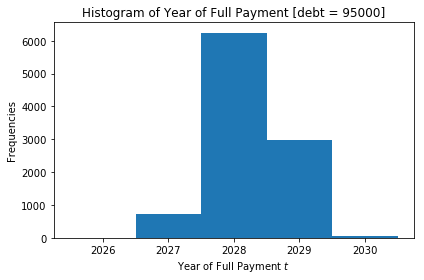

In [21]:
fig, ax = plt.subplots()

plt.hist(debt_yearsB, np.arange(min(debt_yearsB)-.5, max(debt_yearsB) + 1))

plt.xlabel(r'Year of Full Payment $t$')
plt.ylabel('Frequencies')
plt.title(f'Histogram of Year of Full Payment [debt = {debt}]')
plt.xticks(np.arange(min(debt_yearsB), max(debt_yearsB) + 1))

fig.tight_layout()
plt.show()

In what percent of the simulations are you able to pay off the loan in 10 years (on or before 2028)?

In [22]:
len(list(i for i in debt_yearsB if i<= 2028))/len(debt_years)

0.6976

69.76% of the simulations are able to pay off the loan in 10 years (on or before 2028)